# Variational Autoencoder
*Zhiang Chen, March 2017*

Adapted from the blog here: https://jmetzen.github.io/2015-11-27/vae.html

### 1. Import packages

In [47]:
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt
import random
import operator
import time
import os
import math
import deepdish as dd
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
from math import *
import time
import cv2
from scipy.misc import imresize

### 2. Import data

In [75]:
wd = os.getcwd()
os.chdir('..')
file_name = 'depth_data.h5'

save = dd.io.load(file_name)

train_objects = save['train_objects']
train_orientations = save['train_orientations']
train_values = save['train_values'] - 0.15
valid_objects = save['valid_objects']
valid_orientations = save['valid_orientations']
valid_values = save['valid_values'] - 0.15
test_objects = save['test_objects']
test_orientations = save['test_orientations']
test_values = save['test_values'] - 0.15
value2object = save['value2object']
object2value = save['object2value']
del save

os.chdir(wd)

print('training dataset', train_objects.shape, train_orientations.shape, train_values.shape)
print('validation dataset', valid_objects.shape, valid_orientations.shape, valid_values.shape)
print('testing dataset', test_objects.shape, test_orientations.shape, test_values.shape)

('training dataset', (427680, 11), (427680, 10), (427680, 40, 40, 1))
('validation dataset', (71226, 11), (71226, 10), (71226, 40, 40, 1))
('testing dataset', (71280, 11), (71280, 10), (71280, 40, 40, 1))


### 3. Shuffle data

In [76]:
image_size = 40

def randomize(dataset, classes, angles):
    permutation = np.random.permutation(classes.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_classes = classes[permutation]
    shuffled_angles = angles[permutation]
    return shuffled_dataset, shuffled_classes, shuffled_angles

train_dataset, train_classes, train_angles = randomize(train_values, train_objects, train_orientations)
valid_dataset, valid_classes, valid_angles = randomize(valid_values, valid_objects, valid_orientations)
test_dataset, test_classes, test_angles = randomize(test_values, test_objects, test_orientations)

valid_dataset = valid_dataset[:5000,:,:,:]
valid_angles = valid_angles[:5000,:]
valid_classes = valid_classes[:5000,:]

test_dataset = test_dataset[:5000,:,:,:]
test_angles = test_angles[:5000,:]
test_classes = test_classes[:5000,:]

train_dataset = train_dataset.reshape(-1,image_size*image_size)
valid_dataset = valid_dataset.reshape(-1,image_size*image_size)
test_dataset = test_dataset.reshape(-1,image_size*image_size)
n_samples = train_dataset.shape[0]

del train_values, train_objects, train_orientations
del valid_values, valid_objects, valid_orientations
del test_values, test_objects, test_orientations

In [66]:
'''MNIST'''
#image_size = 28
mnist = read_data_sets('MNIST_data', one_hot=True)
n_samples = mnist.train.num_examples
train_dataset = mnist.train.images
test_dataset = mnist.test.images


def image_resize(images, height, width):
    images = images.reshape(-1,28,28)
    resized_images = np.asarray([imresize(image, (height, width)) for image in images]).astype(np.float32)
    return resized_images


train_dataset = image_resize(train_dataset, image_size, image_size)
train_dataset = train_dataset.reshape(-1,image_size*image_size)

test_dataset = image_resize(test_dataset, image_size, image_size)
test_dataset = test_dataset.reshape(-1,image_size*image_size)

#plt.imshow(train_dataset[0,:],cmap='Greys_r',vmin=-0.6,vmax=0.4)
#plt.show()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### 4. Define some functions

In [63]:
np.random.seed(0)
tf.set_random_seed(0)

def accuracy_classes(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

def xavier_init(fan_in, fan_out, constant=1): 
    """ Xavier initialization of network weights"""
    # https://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
    low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
    high = constant*np.sqrt(6.0/(fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), 
                             minval=low, maxval=high, 
                             dtype=tf.float32)

### 5. VAE

In [64]:
class VariationalAutoencoder(object):
    """ Variation Autoencoder (VAE) with an sklearn-like interface implemented using TensorFlow.
    
    This implementation uses probabilistic encoders and decoders using Gaussian 
    distributions and  realized by multi-layer perceptrons. The VAE can be learned
    end-to-end.
    
    See "Auto-Encoding Variational Bayes" by Kingma and Welling for more details.
    """
    def __init__(self, network_architecture, transfer_fct=tf.nn.softplus, 
                 learning_rate=0.001, batch_size=100):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
        # tf Graph input
        self.x = tf.placeholder(tf.float32, [batch_size, network_architecture["n_input"]])
        self.y = tf.placeholder(tf.float32, [batch_size, network_architecture["n_clas"]])
        self.image_size = float(network_architecture["n_input"])
        
        self.tf_valid_dataset = tf.constant(valid_dataset)
        self.tf_test_dataset = tf.constant(test_dataset)
        
        # Create autoencoder network
        self.training_status = False
        self._create_network()
        # Define loss function based variational upper-bound and 
        # corresponding optimizer
        self._create_loss_optimizer()
        
        # Initializing the tensor flow variables
        init = tf.global_variables_initializer()

        # Launch the session
        config = tf.ConfigProto()
        config.gpu_options.allow_growth=True
        config.log_device_placement = True
        config.gpu_options.allocator_type = 'BFC' 
        self.sess = tf.InteractiveSession(config = config)
        self.sess.run(init)
    
    def _create_network(self):
        # Initialize autoencode network weights and biases
        self.network_weights = self._initialize_weights(**self.network_architecture)

        # Use recognition network to determine mean and 
        # (log) variance of Gaussian distribution in latent
        # space
        self.z_mean, self.z_log_sigma_sq = \
            self._recognition_network(self.network_weights["weights_recog"], 
                                      self.network_weights["biases_recog"])

        # Draw one sample z from Gaussian distribution
        n_z = self.network_architecture["n_z"]
        eps = tf.random_normal((self.batch_size, n_z), 0, 1, 
                               dtype=tf.float32)
        # z = mu + sigma*epsilon
        self.z = tf.add(self.z_mean, 
                        tf.multiply(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))

        # Use generator to determine mean of
        # Bernoulli distribution of reconstructed input
        self.x_reconstr_mean, self.x_reconstr_log_sigma_sq = \
            self._generator_network(self.network_weights["weights_gener"],
                                    self.network_weights["biases_gener"])
        
        # Retrain network
        self.logits = self._retrain_network(self.network_weights["classifier"], self.network_weights["bias_classifier"])
        
        self.test_prediction = self._evaluate(self.tf_test_dataset, self.network_weights["weights_recog"],\
                                              self.network_weights["biases_recog"], self.network_weights["classifier"],\
                                              self.network_weights["bias_classifier"])
        
        self.valid_prediction = self._evaluate(self.tf_valid_dataset, self.network_weights["weights_recog"],\
                                              self.network_weights["biases_recog"], self.network_weights["classifier"],\
                                              self.network_weights["bias_classifier"])

            
    def _initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2, 
                            n_hidden_gener_1,  n_hidden_gener_2, 
                            n_input, n_z, n_hidden_clas, n_clas):
        all_weights = dict()
        all_weights['weights_recog'] = {
            'h1': tf.Variable(xavier_init(n_input, n_hidden_recog_1)),
            'h2': tf.Variable(xavier_init(n_hidden_recog_1, n_hidden_recog_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_recog_2, n_z)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_recog_2, n_z))}
        all_weights['biases_recog'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_recog_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_recog_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32))}
        all_weights['weights_gener'] = {
            'h1': tf.Variable(xavier_init(n_z, n_hidden_gener_1)),
            'h2': tf.Variable(xavier_init(n_hidden_gener_1, n_hidden_gener_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_gener_2, n_input)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_gener_2, n_input))}
        all_weights['biases_gener'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_gener_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_input], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
        all_weights['classifier'] = {
            'h1': tf.Variable(xavier_init(n_z, n_hidden_clas)),
            'classes': tf.Variable(xavier_init(n_hidden_clas, n_clas))
        }
        all_weights['bias_classifier'] = {
            'h1': tf.Variable(tf.zeros([n_hidden_clas], dtype=tf.float32)),
            'classes': tf.Variable(tf.zeros([n_clas], dtype=tf.float32))
        }
        return all_weights
            
    def _recognition_network(self, weights, biases):
        # Generate probabilistic encoder (recognition network), which
        # maps inputs onto a normal distribution in latent space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.x, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        z_mean = tf.add(tf.matmul(layer_2, weights['out_mean']),
                        biases['out_mean'])
        z_log_sigma_sq = \
            tf.add(tf.matmul(layer_2, weights['out_log_sigma']), 
                   biases['out_log_sigma'])
        return (z_mean, z_log_sigma_sq)

    def _generator_network(self, weights, biases):
        # Generate probabilistic decoder (decoder network), which
        # maps points in latent space onto a Bernoulli distribution in data space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.z, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        x_reconstr_mean = tf.add(tf.matmul(layer_2, weights['out_mean']),biases['out_mean'])
        
        #x_reconstr_mean = tf.sigmoid(tf.add(tf.matmul(layer_2, weights['out_mean']),biases['out_mean']))
            
        x_reconstr_log_sigma_sq = \
            tf.add(tf.matmul(layer_2, weights['out_log_sigma']),
                                 biases['out_log_sigma'])
            
        return x_reconstr_mean, x_reconstr_log_sigma_sq
            
    def _create_loss_optimizer(self):
        '''
        # The loss is composed of two terms:
        # 1.) The reconstruction loss (the negative log probability
        #     of the input under the reconstructed Bernoulli distribution 
        #     induced by the decoder in the data space).
        #     This can be interpreted as the number of "nats" required
        #     for reconstructing the input when the activation in latent
        #     is given.
        # Adding 1e-10 to avoid evaluation of log(0.0)
        self.disp = self.x_reconstr_mean
        self.reconstr_loss = \
            -tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr_mean)
                           + (1-self.x) * tf.log(1e-10 + 1 - self.x_reconstr_mean),
                           1)
        '''
        
        # The p(x|z) has multi-Gaussian distribution
        sigma_sq = tf.exp(self.x_reconstr_log_sigma_sq)
        inverse_sigma_sq = tf.matrix_diag(tf.reciprocal(sigma_sq))
        x_u = tf.reshape(self.x-self.x_reconstr_mean, [self.batch_size, tf.shape(self.x)[1],1])
        log_factor = -0.5*tf.matmul(tf.matmul(tf.transpose(x_u, perm=[0, 2, 1]),inverse_sigma_sq), x_u)
        log_factor = tf.reshape(log_factor,[self.batch_size])

        det = tf.reduce_sum(tf.log(1e-10+sigma_sq), axis=1)
        s_log = -0.5*tf.reduce_sum(tf.log(1e-10+sigma_sq), axis=1)
        p = tf.constant((2*pi)**(-self.image_size/2))*tf.ones(self.batch_size,tf.float32)
        reconstr_p = log_factor + tf.log(p+1e-10) + s_log 
        self.reconstr_loss = - reconstr_p
        
        # Using MSE as the reconstruction error
        #self.reconstr_loss = tf.reduce_mean(tf.square(self.x-self.x_reconstr_mean),axis=1)
        
        #print self.reconstr_loss
        self.disp = self.reconstr_loss
        #print(reconstr_p.get_batch_shape())
        #print(reconstr_p.get_event_shape())
        #'''
        

        
        # 2.) The latent loss, which is defined as the Kullback Leibler divergence 
        ##    between the distribution in latent space induced by the encoder on 
        #     the data and some prior. This acts as a kind of regularizer.
        #     This can be interpreted as the number of "nats" required
        #     for transmitting the the latent space distribution given
        #     the prior.
        self.latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq 
                                           - tf.square(self.z_mean) 
                                           - tf.exp(self.z_log_sigma_sq), 1)
        self.cost = tf.reduce_mean(self.reconstr_loss + self.latent_loss)   # average over batch
        # Use ADAM optimizer
        self.optimizer = \
            tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
            
            
        self.retrain_loss = \
            tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = self.logits, \
                                                                   labels = self.y))
        self.retrain_optimizer = \
            tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.retrain_loss)
        
    def partial_fit(self, X):
        """Train model based on mini-batch of input data.
        
        Return cost of mini-batch.
        """
        opt, cost,l,r,disp = self.sess.run((self.optimizer, self.cost, self.latent_loss, self.reconstr_loss, self.disp), 
                                  feed_dict={self.x: X})
        return cost,l,r,disp
    
    def transform(self, X):
        """Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.z_mean, feed_dict={self.x: X})
    
    def generate(self, z_mu=None):
        """ Generate data by sampling from latent space.
        
        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent 
        space.        
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.z: z_mu})
    
    def reconstruct(self, X):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.x: X})
    
    def _retrain_network(self, weights, biases):
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.z, weights['h1']), 
                                           biases['h1'])) 
        logits = tf.add(tf.matmul(layer_1, weights['classes']), biases['classes'])
        return logits 
    
    def retrain(self, X, Y):
        self.training_status = False
        opt, loss = self.sess.run((self.retrain_optimizer, self.retrain_loss), feed_dict={self.x:X, self.y:Y})
        return loss
    
    def _evaluate(self, X, recog_weights, recog_bias, clas_weights, clas_bias):
        hidden1 = self.transfer_fct(tf.add(tf.matmul(X, recog_weights['h1']), recog_bias['b1']))
        hidden2 = self.transfer_fct(tf.add(tf.matmul(hidden1, recog_weights['h2']), recog_bias['b2']))
        hidden3 = self.transfer_fct(tf.add(tf.matmul(hidden2, recog_weights["out_mean"]), recog_bias["out_mean"]))
        hidden4 = self.transfer_fct(tf.add(tf.matmul(hidden3, clas_weights["h1"]), clas_bias["h1"]))
        logits = tf.add(tf.matmul(hidden4, clas_weights["classes"]),clas_bias["classes"])
        return X
    
    def evaluate(self, dataset="validation"):
        if dataset == "validation":
            valid_classes_prediction = tf.nn.softmax(self.valid_prediction)
            return valid_classes_prediction.eval()
        elif dataset == "test":
            test_classes_prediction = tf.nn.softmax(self.test_prediction)
            return test_classes_prediction.eval()
        
    
    def get_trained_weights(self):
        all_weights = dict()
        
        all_weights['weights_recog'] = {
            'h1': self.network_weights['weights_recog']['h1'].eval(),
            'h2': self.network_weights['weights_recog']['h2'].eval(),
            'out_mean': self.network_weights['weights_recog']['out_mean'].eval(),
            'out_log_sigma': self.network_weights['weights_recog']['out_log_sigma'].eval()}
        all_weights['biases_recog'] = {
            'b1': self.network_weights['biases_recog']['b1'].eval(),
            'b2': self.network_weights['biases_recog']['b2'].eval(),
            'out_mean': self.network_weights['biases_recog']['out_mean'].eval(),
            'out_log_sigma': self.network_weights['biases_recog']['out_log_sigma'].eval()}
        all_weights['weights_gener'] = {
            'h1': self.network_weights['weights_gener']['h1'].eval(),
            'h2': self.network_weights['weights_gener']['h2'].eval(),
            'out_mean': self.network_weights['weights_gener']['out_mean'].eval(),
            'out_log_sigma': self.network_weights['weights_gener']['out_log_sigma'].eval()}
        all_weights['biases_gener'] = {
            'b1': self.network_weights['biases_gener']['b1'].eval(),
            'b2': self.network_weights['biases_gener']['b2'].eval(),
            'out_mean': self.network_weights['biases_gener']['out_mean'].eval(),
            'out_log_sigma': self.network_weights['biases_gener']['out_log_sigma'].eval()}
        return all_weights

### 6. Train 

In [67]:
def train(network_architecture, learning_rate=0.001, transfer_fct=tf.nn.softplus,
          batch_size=100, training_epochs=100, display_step=5000):
    vae = VariationalAutoencoder(network_architecture, 
                                 learning_rate=learning_rate, 
                                 batch_size=batch_size,
                                 transfer_fct=transfer_fct)
    
    sum_cost = 0.0
    for epoch in range(training_epochs):
        step = epoch+1
        offset = (step * batch_size) % (train_dataset.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :]
        cost,l,r,disp = vae.partial_fit(batch_data)
        sum_cost += cost
        if ((step % display_step == 0) | (step==1)):
            avg_step = sum_cost/step
            print("Epoch:", '%d' % (step), "cost", "{:.9f}".format(avg_step))
            #print('latent_loss:')
            #print(l)
            #print('reconstr_loss')
            #print(r)
            #print('disp')
            #print(disp)
            
    return vae

#'''
network_architecture = \
    dict(n_hidden_recog_1=1000, # 1st layer encoder neurons
         n_hidden_recog_2=600, # 2nd layer encoder neurons
         n_hidden_gener_1=600, # 1st layer decoder neurons
         n_hidden_gener_2=1000, # 2nd layer decoder neurons
         n_input=1600, # MNIST data input (img shape: 28*28)
         n_z=100,  # dimensionality of latent space
         n_hidden_clas = 50, # 1st hidden layer classifer neurons
         n_clas = 11) # Number of classes
'''
network_architecture = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=784, # MNIST data input (img shape: 28*28)
         n_z=20,  # dimensionality of latent space
         n_hidden_clas = 50)

#'''
start_time = time.time()
vae = train(network_architecture, training_epochs=2000, learning_rate=0.0001, transfer_fct=tf.nn.tanh)
end_time = time.time()

duration = (end_time - start_time)/60
print("Excution time: %0.2fmin" % duration)

('Epoch:', '1', 'cost', '5946308.000000000')
Excution time: 1.53min


In [71]:
batch_size = vae.batch_size

def train2(vae, training_epochs,display_step = 5000):
    sum_cost = 0.0
    for epoch in range(training_epochs):
        step = epoch+1
        offset = (step * batch_size) % (train_dataset.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :]
        cost,l,r,disp = vae.partial_fit(batch_data)
        sum_cost += cost
        if ((step % display_step == 0) | (step==1)):
            avg_step = sum_cost/step
            print("Epoch:", '%d' % (step), "cost", "{:.9f}".format(avg_step))
            #print('latent_loss:')
            #print(l)
            #print('reconstr_loss')
            #print(r)
            #print('disp')
            #print(disp)
            
    return vae

vae = train2(vae,100000)

('Epoch:', '1', 'cost', '2661.762207031')
('Epoch:', '5000', 'cost', '1446.491236193')


KeyboardInterrupt: 

### 7. Test

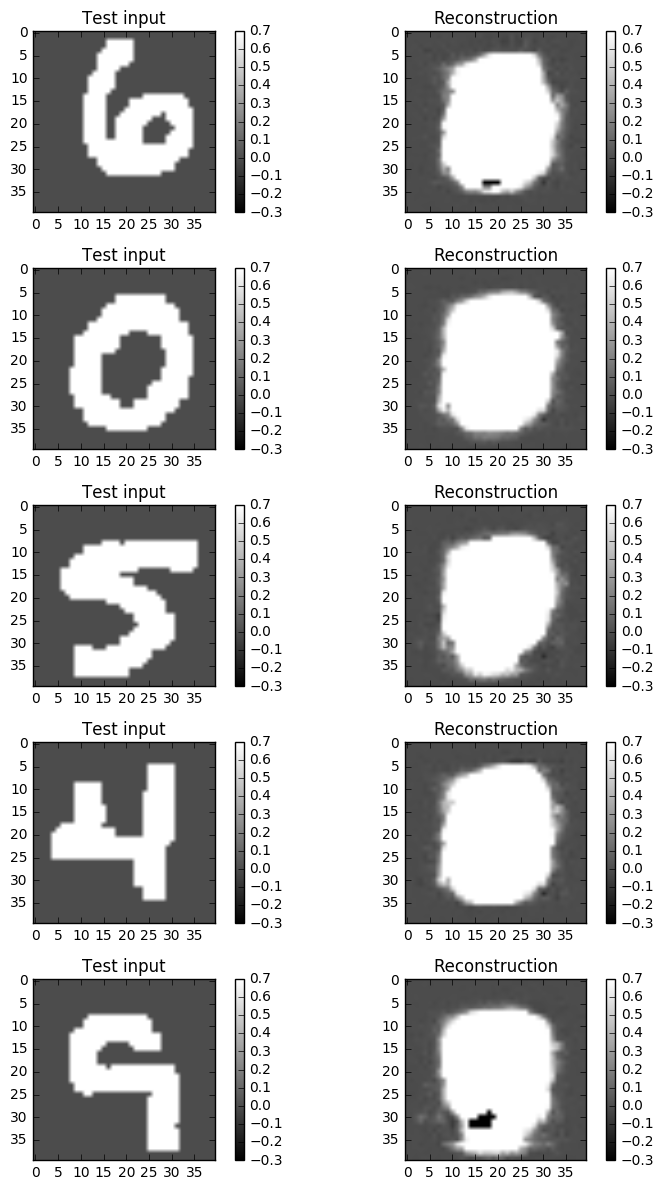

In [70]:
x_start = 100

x_sample = test_dataset[x_start:x_start+100,:]
x_reconstruct = vae.reconstruct(x_sample)

plt.figure(figsize=(8, 12))
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(image_size, image_size), vmin=-0.3, vmax=0.7, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(x_reconstruct[i].reshape(image_size, image_size), vmin=-0.3, vmax=0.7, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()
plt.show()

### 8. Retrain

In [72]:
def leaky_relu(x, leak=0.1):
    return tf.maximum(x, x * leak)

In [83]:
n_input = network_architecture['n_input']
n_z = network_architecture['n_z']
n_hidden_recog_1 = network_architecture['n_hidden_recog_1']
n_hidden_recog_2 = network_architecture['n_hidden_recog_2']
n_hidden_gener_1 = network_architecture['n_hidden_gener_1']
n_hidden_gener_2 = network_architecture['n_hidden_gener_2']

hidden_class = 100
nm_class = 11

hidden_angle = 100
nm_angle = 10

activation_fnc = leaky_relu
TRIANABLE = True

trained_weights = vae.get_trained_weights()
USING_RETRAINED_WEIGHTS = True


recog_weights = trained_weights["weights_recog"]
recog_bias = trained_weights["biases_recog"]

        

graph = tf.Graph()
with graph.as_default():
    '''Input data'''
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size*image_size))
    # k1_depth = input_channels
    # convolution's input is a tensor of shape [batch,in_height,in_width,in_channels]
    tf_train_classes = tf.placeholder(tf.float32, shape=(batch_size, 11))
    tf_train_angles = tf.placeholder(tf.float32, shape=(batch_size, 10))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    '''Initialization'''
    if USING_RETRAINED_WEIGHTS:
        recog_h1_weights = tf.Variable(recog_weights['h1'], trainable = TRIANABLE)
        recog_h1_biases = tf.Variable(recog_bias['b1'], trainable = TRIANABLE)

        recog_h2_weights = tf.Variable(recog_weights['h2'], trainable = TRIANABLE)
        recog_h2_biases = tf.Variable(recog_bias['b2'], trainable = TRIANABLE)

        recog_z_mean_weights = tf.Variable(recog_weights['out_mean'], trainable = TRIANABLE)
        recog_z_mean_biases = tf.Variable(recog_bias['out_mean'], trainable = TRIANABLE)

        recog_z_var_weights = tf.Variable(recog_weights['out_log_sigma'], trainable = TRIANABLE)
        recog_z_var_biases = tf.Variable(recog_bias['out_log_sigma'], trainable = TRIANABLE)
    else:
        recog_h1_weights = tf.Variable(xavier_init(n_input, n_hidden_recog_1))
        recog_h1_biases = np.zeros(n_hidden_recog_1, dtype=np.float32)

        recog_h2_weights = tf.Variable(xavier_init(n_hidden_recog_1, n_hidden_recog_2))
        recog_h2_biases = np.zeros(n_hidden_recog_2, dtype=np.float32)

        recog_z_mean_weights = xavier_init(n_hidden_recog_2, n_z)
        recog_z_mean_biases = np.zeros(n_z, dtype=np.float32)

        recog_z_var_weights = xavier_init(n_hidden_recog_2, n_z)
        recog_z_var_biases = np.zeros(n_z, dtype=np.float32)        
    
    
    ## class FC
    n_z_cat = n_z*2
    hidden_class_stddev = math.sqrt(2.0/hidden_class)
    hidden_class_weights = tf.Variable(tf.truncated_normal([n_z_cat, hidden_class], stddev = hidden_class_stddev), \
                                       trainable = True)
    hidden_class_biases = tf.Variable(tf.zeros([hidden_class]),\
                                      trainable = True)
    
    class_stddev = math.sqrt(2.0/nm_class)
    class_weights = tf.Variable(tf.truncated_normal([hidden_class, nm_class], stddev = class_stddev), \
                               trainable = True)
    class_biases = tf.Variable(tf.zeros([nm_class]), \
                              trainable = True)
    
    
    ## angle FC
    hidden_angle_stddev = math.sqrt(2.0/hidden_angle)
    hidden_angle_weights = tf.Variable(tf.truncated_normal([n_z_cat, hidden_angle], stddev = hidden_angle_stddev),\
                                      trainable = True)
    hidden_angle_biases = tf.Variable(tf.zeros([hidden_angle]), \
                                     trainable = True)
    
    angle_stddev = math.sqrt(2.0/nm_angle)
    angle_weights = tf.Variable(tf.truncated_normal([hidden_angle, nm_angle], stddev = angle_stddev), \
                               trainable = True)
    angle_biases = tf.Variable(tf.zeros([nm_angle]), \
                              trainable = True)

    saver = tf.train.Saver()
    '''Models'''
        
    def model(data):
        hidden1 = activation_fnc(tf.matmul(data, recog_h1_weights) + recog_h1_biases)
        hidden2 = activation_fnc(tf.matmul(hidden1, recog_h2_weights) + recog_h2_biases)
        z_mean = tf.matmul(hidden2, recog_z_mean_weights) + recog_z_mean_biases
        z_var = tf.matmul(hidden2, recog_z_var_weights) + recog_z_var_biases
        
        z_cat = tf.concat([z_mean,z_var],1)
        z_hidden = z_cat
        
        ## class FC
        class_fc = tf.matmul(z_hidden, hidden_class_weights)
        class_hidden = activation_fnc(class_fc + hidden_class_biases)
        fc_classes = tf.matmul(class_hidden, class_weights)
        output_classes = fc_classes + class_biases
        
        ## angle FC
        angle_fc = tf.matmul(z_hidden, hidden_angle_weights)
        angle_hidden = activation_fnc(angle_fc + hidden_angle_biases)
        fc_angles = tf.matmul(angle_hidden, angle_weights)
        output_angles = fc_angles + angle_biases
    
        return output_classes, output_angles
    
    '''Optimizer'''
    logits_classes, logits_angles = model(tf_train_dataset)
    loss_classes = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits_classes, \
                                                                          labels = tf_train_classes))
    loss_angles = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits_angles, \
                                                                         labels = tf_train_angles))
    loss = 0.65*loss_classes + 0.35*loss_angles
    optimizer = tf.train.AdamOptimizer(0.0005).minimize(loss)
    # maybe better opt
    
    '''Predictions'''
    train_classes_logits,train_angles_logits  = model(tf_train_dataset)
    train_classes_prediction = tf.nn.softmax(train_classes_logits)
    train_angles_prediction = tf.nn.softmax(train_angles_logits)
    
    valid_classes_logits, valid_angles_logits = model(tf_valid_dataset)
    valid_classes_prediction = tf.nn.softmax(valid_classes_logits)
    valid_angles_prediction = tf.nn.softmax(valid_angles_logits)
    
    test_classes_logits, test_angles_logits = model(tf_test_dataset)
    test_classes_prediction = tf.nn.softmax(test_classes_logits)
    test_angles_prediction = tf.nn.softmax(test_angles_logits)

In [85]:
def accuracy_classes(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

start_time = time.time()

num_steps = 15000
batch_size = vae.batch_size
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
config.log_device_placement = True
config.gpu_options.allocator_type = 'BFC'  
with tf.Session(graph=graph, config = config) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_classes.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_classes = train_classes[offset:(offset + batch_size), :]
    batch_angles = train_angles[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_classes : batch_classes, tf_train_angles : batch_angles}
    _, l, classes_predictions, angles_predictions = session.run(
      [optimizer, loss, train_classes_prediction, train_angles_prediction], feed_dict=feed_dict)
    if ((step+1) % 500 == 0):
      epoch = step+1
      print('Minibatch loss at step %d: %f' % (epoch, l))
      print('Minibatch classes accuracy: %.1f%%' % accuracy_classes(classes_predictions, batch_classes))
      print('Validation classes accuracy: %.1f%%' % accuracy_classes(valid_classes_prediction.eval(), valid_classes))
      print('Minibatch angles accuracy: %.1f%%' % accuracy_classes(angles_predictions, batch_angles))
      print('Validation angles accuracy: %.1f%%' % accuracy_classes(valid_angles_prediction.eval(), valid_angles))
      print('--------------------------------------')
  print('Test classes accuracy: %.1f%%' % accuracy_classes(test_classes_prediction.eval(), test_classes))
  print('Test angles accuracy: %.1f%%' % accuracy_classes(test_angles_prediction.eval(), test_angles))
  end_time = time.time()
  duration = (end_time - start_time)/60
  print("Excution time: %0.2fmin" % duration)
  save_path = saver.save(session, "./model.ckpt")
  print("Model saved in file: %s" % save_path)

Initialized
Minibatch loss at step 500: 0.637713
Minibatch classes accuracy: 86.0%
Validation classes accuracy: 81.0%
Minibatch angles accuracy: 64.0%
Validation angles accuracy: 63.1%
--------------------------------------
Minibatch loss at step 1000: 0.377402
Minibatch classes accuracy: 94.0%
Validation classes accuracy: 91.8%
Minibatch angles accuracy: 70.0%
Validation angles accuracy: 75.9%
--------------------------------------
Minibatch loss at step 1500: 0.238430
Minibatch classes accuracy: 93.0%
Validation classes accuracy: 93.0%
Minibatch angles accuracy: 82.0%
Validation angles accuracy: 79.7%
--------------------------------------
Minibatch loss at step 2000: 0.249620
Minibatch classes accuracy: 95.0%
Validation classes accuracy: 94.2%
Minibatch angles accuracy: 82.0%
Validation angles accuracy: 80.4%
--------------------------------------
Minibatch loss at step 2500: 0.144102
Minibatch classes accuracy: 98.0%
Validation classes accuracy: 94.0%
Minibatch angles accuracy: 85.